In [1]:
import os
import numpy as np
import librosa
import soundfile as sf

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import os
import numpy as np
import librosa
from tqdm import tqdm
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [5]:
import soundfile as sf


In [6]:
import os, glob, random
import numpy as np
import librosa
import soundfile as sf
import torch

from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


C:\Users\Dell\Downloads\emotion_det\emotion\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [13]:
y_true = []
y_pred = []

In [14]:
import os
import numpy as np
import librosa
import joblib
import pandas as pd
import torch
from keras.models import load_model
from voice_gender_classifier.model import ECAPA_gender
from tqdm import tqdm

# Emotion mapping
int_to_emotion = {
    0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad',
    4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'
}
def get_emotion_label(filename):
   
    base = os.path.basename(filename)
    parts = base.split('-')
    emotion_id = int(parts[2])
    return emotion_id - 1 

# Load models and scalers
model_female = load_model("female_models/female_model.keras")
model_male = load_model("male_models/male_model.keras")
scaler_female = joblib.load("female_models/female_scaler.pkl")
scaler_male = joblib.load("male_models/male_scaler.pkl")

# Load gender classification model
gender_model = ECAPA_gender.from_pretrained("JaesungHuh/voice-gender-classifier")
gender_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gender_model.to(device)

def predict_gender(file_path):
    with torch.no_grad():
        return gender_model.predict(file_path, device=device)

def extract_features(audio, sr, n_mfcc=40, n_chroma=12, n_bands=6):
    stft = np.abs(librosa.stft(audio))
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_processed = np.vstack([np.mean(mfccs, axis=1), np.std(mfccs, axis=1), np.median(mfccs, axis=1)])
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr, n_chroma=n_chroma)
    chroma_processed = np.vstack([np.mean(chroma, axis=1), np.std(chroma, axis=1)])
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr, n_bands=n_bands)
    contrast_processed = np.vstack([np.mean(contrast, axis=1), np.std(contrast, axis=1)])
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)
    tonnetz_processed = np.vstack([np.mean(tonnetz, axis=1), np.std(tonnetz, axis=1)])
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    flatness = librosa.feature.spectral_flatness(y=audio)
    spectral_features = np.array([np.mean(centroid), np.std(centroid), np.mean(bandwidth), np.std(bandwidth),
                                  np.mean(rolloff), np.std(rolloff), np.mean(flatness), np.std(flatness)])
    zero_crossing = librosa.feature.zero_crossing_rate(audio)
    rms = librosa.feature.rms(y=audio)
    temporal_features = np.array([np.mean(zero_crossing), np.std(zero_crossing), np.mean(rms), np.std(rms)])
    mel = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_processed = np.array([np.mean(mel), np.std(mel), np.median(mel), np.max(mel)])
    return np.hstack([mfccs_processed.flatten(), chroma_processed.flatten(), contrast_processed.flatten(),
                      tonnetz_processed.flatten(), spectral_features, temporal_features, mel_processed])

# ----------- MAIN --------------
def process_folder(folder_path):
    if not os.path.isdir(folder_path):
        print("❌ Invalid folder path.")
        return

    wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    if not wav_files:
        print("⚠️ No `.wav` files found in the folder.")
        return

    results = []

    print(f"\n🔍 Found {len(wav_files)} files. Processing...\n")

    for filename in tqdm(wav_files):
        file_path = os.path.join(folder_path, filename)

        try:
            gender = predict_gender(file_path)
            audio, sr = librosa.load(file_path, sr=16000)
            features = extract_features(audio, sr)
            y_true.append(get_emotion_label(filename))

            if gender == 'female':
                features_scaled = scaler_female.transform([features])
                features_input = features_scaled.reshape((1, features_scaled.shape[1], 1))
                probs = model_female.predict(features_input)[0]
            else:
                features_scaled = scaler_male.transform([features])
                features_input = features_scaled.reshape((1, features_scaled.shape[1], 1))
                probs = model_male.predict(features_input)[0]
            y_pred.append(np.argmax(probs))

            predicted_emotion = int_to_emotion[np.argmax(probs)]
            results.append((filename, gender, predicted_emotion))

        except Exception as e:
            results.append((filename, "Error", str(e)))

    df = pd.DataFrame(results, columns=["Filename", "Gender", "Predicted Emotion"])
    output_csv = os.path.join(folder_path, "emotion_predictions.csv")
    df.to_csv(output_csv, index=False)
    print(f"\n✅ Results saved to: {output_csv}\n")
    print(df)


if __name__ == "__main__":
    folder = input("Enter the path to folder containing .wav files: ").strip()
    process_folder(folder)
    print(result)


Enter the path to folder containing .wav files:  C:\Users\Dell\Downloads\emotion_det\final3\combined



🔍 Found 491 files. Processing...



  0%|                                                                                          | 0/491 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


  0%|▏                                                                                 | 1/491 [00:03<26:57,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


  0%|▎                                                                                 | 2/491 [00:06<25:44,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  1%|▌                                                                                 | 3/491 [00:09<25:36,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  1%|▋                                                                                 | 4/491 [00:12<24:49,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  1%|▊                                                                                 | 5/491 [00:15<24:55,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  1%|█                                                                                 | 6/491 [00:18<24:50,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


  1%|█▏                                                                                | 7/491 [00:21<24:44,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  2%|█▎                                                                                | 8/491 [00:24<24:07,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  2%|█▌                                                                                | 9/491 [00:27<24:18,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  2%|█▋                                                                               | 10/491 [00:30<24:48,  3.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


  2%|█▊                                                                               | 11/491 [00:33<24:41,  3.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


  2%|█▉                                                                               | 12/491 [00:36<24:15,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  3%|██▏                                                                              | 13/491 [00:39<24:26,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


  3%|██▎                                                                              | 14/491 [00:42<24:18,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  3%|██▍                                                                              | 15/491 [00:46<24:19,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  3%|██▋                                                                              | 16/491 [00:48<23:43,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  3%|██▊                                                                              | 17/491 [00:51<21:49,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  4%|██▉                                                                              | 18/491 [00:52<18:51,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  4%|███▏                                                                             | 19/491 [00:53<16:10,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  4%|███▎                                                                             | 20/491 [00:55<14:20,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  4%|███▍                                                                             | 21/491 [00:56<13:40,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  4%|███▋                                                                             | 22/491 [00:58<12:40,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  5%|███▊                                                                             | 23/491 [00:59<12:24,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  5%|███▉                                                                             | 24/491 [01:01<12:09,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  5%|████                                                                             | 25/491 [01:02<12:11,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  5%|████▎                                                                            | 26/491 [01:04<12:02,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  5%|████▍                                                                            | 27/491 [01:05<11:17,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|████▌                                                                            | 28/491 [01:06<10:55,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  6%|████▊                                                                            | 29/491 [01:08<10:49,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  6%|████▉                                                                            | 30/491 [01:09<10:43,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  6%|█████                                                                            | 31/491 [01:11<11:00,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|█████▎                                                                           | 32/491 [01:12<10:39,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  7%|█████▍                                                                           | 33/491 [01:13<10:27,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  7%|█████▌                                                                           | 34/491 [01:15<10:39,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  7%|█████▊                                                                           | 35/491 [01:16<10:27,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  7%|█████▉                                                                           | 36/491 [01:17<10:28,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  8%|██████                                                                           | 37/491 [01:19<10:24,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|██████▎                                                                          | 38/491 [01:20<10:21,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|██████▍                                                                          | 39/491 [01:22<10:34,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  8%|██████▌                                                                          | 40/491 [01:23<10:33,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  8%|██████▊                                                                          | 41/491 [01:25<10:50,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|██████▉                                                                          | 42/491 [01:26<10:51,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  9%|███████                                                                          | 43/491 [01:27<10:52,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  9%|███████▎                                                                         | 44/491 [01:29<11:33,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  9%|███████▍                                                                         | 45/491 [01:31<11:39,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|███████▌                                                                         | 46/491 [01:33<12:01,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 10%|███████▊                                                                         | 47/491 [01:34<11:52,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 10%|███████▉                                                                         | 48/491 [01:36<11:27,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|████████                                                                         | 49/491 [01:37<11:10,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|████████▏                                                                        | 50/491 [01:38<11:03,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 10%|████████▍                                                                        | 51/491 [01:40<11:14,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|████████▌                                                                        | 52/491 [01:42<11:00,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|████████▋                                                                        | 53/491 [01:43<11:28,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|████████▉                                                                        | 54/491 [01:45<10:54,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|█████████                                                                        | 55/491 [01:46<10:34,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 11%|█████████▏                                                                       | 56/491 [01:47<10:13,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 12%|█████████▍                                                                       | 57/491 [01:49<10:03,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 12%|█████████▌                                                                       | 58/491 [01:50<10:08,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 12%|█████████▋                                                                       | 59/491 [01:51<09:47,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 12%|█████████▉                                                                       | 60/491 [01:53<09:46,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 12%|██████████                                                                       | 61/491 [01:54<09:34,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 13%|██████████▏                                                                      | 62/491 [01:55<09:32,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 13%|██████████▍                                                                      | 63/491 [01:57<09:31,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 13%|██████████▌                                                                      | 64/491 [01:58<09:29,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|██████████▋                                                                      | 65/491 [01:59<09:26,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 13%|██████████▉                                                                      | 66/491 [02:01<09:23,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|███████████                                                                      | 67/491 [02:02<09:26,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 14%|███████████▏                                                                     | 68/491 [02:03<09:18,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|███████████▍                                                                     | 69/491 [02:04<09:11,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|███████████▌                                                                     | 70/491 [02:06<09:10,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|███████████▋                                                                     | 71/491 [02:07<09:04,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 15%|███████████▉                                                                     | 72/491 [02:08<09:10,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 15%|████████████                                                                     | 73/491 [02:10<09:17,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 15%|████████████▏                                                                    | 74/491 [02:11<09:12,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|████████████▎                                                                    | 75/491 [02:12<09:20,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 15%|████████████▌                                                                    | 76/491 [02:14<09:02,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 16%|████████████▋                                                                    | 77/491 [02:15<08:47,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 16%|████████████▊                                                                    | 78/491 [02:16<09:08,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 16%|█████████████                                                                    | 79/491 [02:18<09:53,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█████████████▏                                                                   | 80/491 [02:19<09:52,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 16%|█████████████▎                                                                   | 81/491 [02:21<09:56,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█████████████▌                                                                   | 82/491 [02:22<09:34,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 17%|█████████████▋                                                                   | 83/491 [02:24<10:03,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 17%|█████████████▊                                                                   | 84/491 [02:25<09:41,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|██████████████                                                                   | 85/491 [02:27<09:30,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|██████████████▏                                                                  | 86/491 [02:28<09:25,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|██████████████▎                                                                  | 87/491 [02:29<09:20,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|██████████████▌                                                                  | 88/491 [02:31<09:18,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|██████████████▋                                                                  | 89/491 [02:32<09:01,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|██████████████▊                                                                  | 90/491 [02:33<09:01,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|███████████████                                                                  | 91/491 [02:35<09:24,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 19%|███████████████▏                                                                 | 92/491 [02:36<09:09,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|███████████████▎                                                                 | 93/491 [02:38<09:05,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 19%|███████████████▌                                                                 | 94/491 [02:39<09:33,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|███████████████▋                                                                 | 95/491 [02:40<09:18,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 20%|███████████████▊                                                                 | 96/491 [02:42<09:13,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|████████████████                                                                 | 97/491 [02:43<09:21,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|████████████████▏                                                                | 98/491 [02:45<09:19,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|████████████████▎                                                                | 99/491 [02:46<08:54,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|████████████████▎                                                               | 100/491 [02:47<08:47,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 21%|████████████████▍                                                               | 101/491 [02:49<08:47,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 21%|████████████████▌                                                               | 102/491 [02:50<08:41,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 21%|████████████████▊                                                               | 103/491 [02:51<08:39,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|████████████████▉                                                               | 104/491 [02:53<08:53,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 21%|█████████████████                                                               | 105/491 [02:54<09:10,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 22%|█████████████████▎                                                              | 106/491 [02:56<08:53,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|█████████████████▍                                                              | 107/491 [02:57<08:47,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 22%|█████████████████▌                                                              | 108/491 [02:58<08:39,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|█████████████████▊                                                              | 109/491 [03:00<08:39,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 22%|█████████████████▉                                                              | 110/491 [03:01<08:38,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 23%|██████████████████                                                              | 111/491 [03:02<08:35,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 23%|██████████████████▏                                                             | 112/491 [03:04<08:43,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|██████████████████▍                                                             | 113/491 [03:05<08:38,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██████████████████▌                                                             | 114/491 [03:06<08:22,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|██████████████████▋                                                             | 115/491 [03:08<08:28,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 24%|██████████████████▉                                                             | 116/491 [03:09<08:25,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 24%|███████████████████                                                             | 117/491 [03:10<08:26,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|███████████████████▏                                                            | 118/491 [03:12<08:13,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|███████████████████▍                                                            | 119/491 [03:13<08:18,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|███████████████████▌                                                            | 120/491 [03:14<08:12,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|███████████████████▋                                                            | 121/491 [03:16<08:19,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|███████████████████▉                                                            | 122/491 [03:17<08:13,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|████████████████████                                                            | 123/491 [03:19<08:21,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 25%|████████████████████▏                                                           | 124/491 [03:20<08:43,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 25%|████████████████████▎                                                           | 125/491 [03:21<08:20,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|████████████████████▌                                                           | 126/491 [03:23<08:10,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|████████████████████▋                                                           | 127/491 [03:24<08:22,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|████████████████████▊                                                           | 128/491 [03:26<08:23,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 26%|█████████████████████                                                           | 129/491 [03:27<08:44,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|█████████████████████▏                                                          | 130/491 [03:28<08:32,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|█████████████████████▎                                                          | 131/491 [03:30<08:17,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|█████████████████████▌                                                          | 132/491 [03:31<08:02,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|█████████████████████▋                                                          | 133/491 [03:32<08:00,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|█████████████████████▊                                                          | 134/491 [03:34<08:04,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 27%|█████████████████████▉                                                          | 135/491 [03:35<08:05,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 28%|██████████████████████▏                                                         | 136/491 [03:36<07:39,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██████████████████████▎                                                         | 137/491 [03:38<07:51,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██████████████████████▍                                                         | 138/491 [03:39<08:07,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██████████████████████▋                                                         | 139/491 [03:41<08:04,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 29%|██████████████████████▊                                                         | 140/491 [03:42<08:14,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|██████████████████████▉                                                         | 141/491 [03:43<08:01,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|███████████████████████▏                                                        | 142/491 [03:45<08:13,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|███████████████████████▎                                                        | 143/491 [03:46<08:01,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 29%|███████████████████████▍                                                        | 144/491 [03:47<07:54,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███████████████████████▋                                                        | 145/491 [03:49<07:39,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███████████████████████▊                                                        | 146/491 [03:50<07:45,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 30%|███████████████████████▉                                                        | 147/491 [03:51<07:51,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 30%|████████████████████████                                                        | 148/491 [03:53<07:43,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|████████████████████████▎                                                       | 149/491 [03:54<07:56,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|████████████████████████▍                                                       | 150/491 [03:56<07:42,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|████████████████████████▌                                                       | 151/491 [03:57<07:33,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|████████████████████████▊                                                       | 152/491 [03:58<07:34,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|████████████████████████▉                                                       | 153/491 [04:00<07:47,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|█████████████████████████                                                       | 154/491 [04:01<07:42,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 32%|█████████████████████████▎                                                      | 155/491 [04:02<07:36,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 32%|█████████████████████████▍                                                      | 156/491 [04:04<07:28,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|█████████████████████████▌                                                      | 157/491 [04:05<07:21,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|█████████████████████████▋                                                      | 158/491 [04:06<07:34,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|█████████████████████████▉                                                      | 159/491 [04:08<07:28,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|██████████████████████████                                                      | 160/491 [04:09<07:31,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|██████████████████████████▏                                                     | 161/491 [04:11<07:43,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|██████████████████████████▍                                                     | 162/491 [04:12<07:51,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|██████████████████████████▌                                                     | 163/491 [04:13<07:43,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 33%|██████████████████████████▋                                                     | 164/491 [04:15<07:46,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|██████████████████████████▉                                                     | 165/491 [04:16<07:29,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|███████████████████████████                                                     | 166/491 [04:18<07:31,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███████████████████████████▏                                                    | 167/491 [04:19<07:23,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 34%|███████████████████████████▎                                                    | 168/491 [04:20<07:05,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|███████████████████████████▌                                                    | 169/491 [04:21<07:00,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|███████████████████████████▋                                                    | 170/491 [04:23<06:58,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███████████████████████████▊                                                    | 171/491 [04:24<06:49,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|████████████████████████████                                                    | 172/491 [04:25<06:40,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|████████████████████████████▏                                                   | 173/491 [04:26<06:48,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|████████████████████████████▎                                                   | 174/491 [04:28<06:48,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|████████████████████████████▌                                                   | 175/491 [04:29<06:44,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|████████████████████████████▋                                                   | 176/491 [04:30<06:34,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|████████████████████████████▊                                                   | 177/491 [04:31<06:32,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|█████████████████████████████                                                   | 178/491 [04:33<06:30,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|█████████████████████████████▏                                                  | 179/491 [04:34<06:21,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|█████████████████████████████▎                                                  | 180/491 [04:35<06:18,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 37%|█████████████████████████████▍                                                  | 181/491 [04:36<06:27,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|█████████████████████████████▋                                                  | 182/491 [04:38<06:35,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|█████████████████████████████▊                                                  | 183/491 [04:39<06:41,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 37%|█████████████████████████████▉                                                  | 184/491 [04:40<06:43,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 38%|██████████████████████████████▏                                                 | 185/491 [04:42<06:40,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|██████████████████████████████▎                                                 | 186/491 [04:43<06:34,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 38%|██████████████████████████████▍                                                 | 187/491 [04:44<06:30,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|██████████████████████████████▋                                                 | 188/491 [04:46<06:36,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 38%|██████████████████████████████▊                                                 | 189/491 [04:47<06:44,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 39%|██████████████████████████████▉                                                 | 190/491 [04:49<07:02,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 39%|███████████████████████████████                                                 | 191/491 [04:50<06:35,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███████████████████████████████▎                                                | 192/491 [04:51<06:25,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███████████████████████████████▍                                                | 193/491 [04:52<06:13,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███████████████████████████████▌                                                | 194/491 [04:53<06:13,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███████████████████████████████▊                                                | 195/491 [04:55<06:01,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 40%|███████████████████████████████▉                                                | 196/491 [04:56<06:09,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|████████████████████████████████                                                | 197/491 [04:57<06:12,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|████████████████████████████████▎                                               | 198/491 [04:58<06:12,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 41%|████████████████████████████████▍                                               | 199/491 [05:00<06:25,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████████████████████████████████▌                                               | 200/491 [05:01<06:30,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 41%|████████████████████████████████▋                                               | 201/491 [05:03<06:24,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████████████████████████████████▉                                               | 202/491 [05:04<06:20,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|█████████████████████████████████                                               | 203/491 [05:05<06:14,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 42%|█████████████████████████████████▏                                              | 204/491 [05:06<06:14,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|█████████████████████████████████▍                                              | 205/491 [05:08<06:45,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|█████████████████████████████████▌                                              | 206/491 [05:09<06:30,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|█████████████████████████████████▋                                              | 207/491 [05:11<06:26,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 42%|█████████████████████████████████▉                                              | 208/491 [05:12<06:14,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 43%|██████████████████████████████████                                              | 209/491 [05:13<06:18,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|██████████████████████████████████▏                                             | 210/491 [05:15<06:23,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 43%|██████████████████████████████████▍                                             | 211/491 [05:16<06:24,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 43%|██████████████████████████████████▌                                             | 212/491 [05:18<06:38,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|██████████████████████████████████▋                                             | 213/491 [05:19<06:31,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 44%|██████████████████████████████████▊                                             | 214/491 [05:21<06:40,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|███████████████████████████████████                                             | 215/491 [05:22<06:49,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|███████████████████████████████████▏                                            | 216/491 [05:24<06:43,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 44%|███████████████████████████████████▎                                            | 217/491 [05:25<06:35,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 44%|███████████████████████████████████▌                                            | 218/491 [05:26<06:18,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|███████████████████████████████████▋                                            | 219/491 [05:28<06:20,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|███████████████████████████████████▊                                            | 220/491 [05:29<06:00,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 45%|████████████████████████████████████                                            | 221/491 [05:30<06:00,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 45%|████████████████████████████████████▏                                           | 222/491 [05:32<06:17,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|████████████████████████████████████▎                                           | 223/491 [05:33<06:25,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 46%|████████████████████████████████████▍                                           | 224/491 [05:35<06:22,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|████████████████████████████████████▋                                           | 225/491 [05:36<06:23,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 46%|████████████████████████████████████▊                                           | 226/491 [05:38<06:28,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 46%|████████████████████████████████████▉                                           | 227/491 [05:39<06:19,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|█████████████████████████████████████▏                                          | 228/491 [05:41<06:36,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|█████████████████████████████████████▎                                          | 229/491 [05:42<06:31,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|█████████████████████████████████████▍                                          | 230/491 [05:44<06:45,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 47%|█████████████████████████████████████▋                                          | 231/491 [05:45<06:30,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|█████████████████████████████████████▊                                          | 232/491 [05:47<06:16,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 47%|█████████████████████████████████████▉                                          | 233/491 [05:48<06:07,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|██████████████████████████████████████▏                                         | 234/491 [05:49<06:04,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|██████████████████████████████████████▎                                         | 235/491 [05:51<06:26,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|██████████████████████████████████████▍                                         | 236/491 [05:52<06:10,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 48%|██████████████████████████████████████▌                                         | 237/491 [05:54<05:56,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|██████████████████████████████████████▊                                         | 238/491 [05:55<06:03,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|██████████████████████████████████████▉                                         | 239/491 [05:57<06:18,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|███████████████████████████████████████                                         | 240/491 [05:58<06:09,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|███████████████████████████████████████▎                                        | 241/491 [06:00<06:11,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|███████████████████████████████████████▍                                        | 242/491 [06:01<06:03,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 49%|███████████████████████████████████████▌                                        | 243/491 [06:03<05:57,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|███████████████████████████████████████▊                                        | 244/491 [06:04<05:50,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|███████████████████████████████████████▉                                        | 245/491 [06:06<06:05,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|████████████████████████████████████████                                        | 246/491 [06:07<05:49,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|████████████████████████████████████████▏                                       | 247/491 [06:08<05:34,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|████████████████████████████████████████▍                                       | 248/491 [06:09<05:27,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|████████████████████████████████████████▌                                       | 249/491 [06:11<05:23,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|████████████████████████████████████████▋                                       | 250/491 [06:12<05:08,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|████████████████████████████████████████▉                                       | 251/491 [06:13<05:13,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████████████████████████████████████████                                       | 252/491 [06:14<05:09,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 52%|█████████████████████████████████████████▏                                      | 253/491 [06:16<04:58,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████████████████████████████████████████▍                                      | 254/491 [06:17<04:59,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████████████████████████████████████████▌                                      | 255/491 [06:18<05:00,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 52%|█████████████████████████████████████████▋                                      | 256/491 [06:20<05:01,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████████████████████████████████████████▊                                      | 257/491 [06:21<05:13,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|██████████████████████████████████████████                                      | 258/491 [06:22<05:01,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|██████████████████████████████████████████▏                                     | 259/491 [06:24<05:02,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 53%|██████████████████████████████████████████▎                                     | 260/491 [06:25<04:56,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|██████████████████████████████████████████▌                                     | 261/491 [06:26<04:47,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 53%|██████████████████████████████████████████▋                                     | 262/491 [06:27<04:49,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|██████████████████████████████████████████▊                                     | 263/491 [06:29<04:51,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 54%|███████████████████████████████████████████                                     | 264/491 [06:30<05:05,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|███████████████████████████████████████████▏                                    | 265/491 [06:31<05:06,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|███████████████████████████████████████████▎                                    | 266/491 [06:33<05:02,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 54%|███████████████████████████████████████████▌                                    | 267/491 [06:34<04:57,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|███████████████████████████████████████████▋                                    | 268/491 [06:35<05:02,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|███████████████████████████████████████████▊                                    | 269/491 [06:37<05:02,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|███████████████████████████████████████████▉                                    | 270/491 [06:38<04:56,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|████████████████████████████████████████████▏                                   | 271/491 [06:40<04:59,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 55%|████████████████████████████████████████████▎                                   | 272/491 [06:41<04:51,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|████████████████████████████████████████████▍                                   | 273/491 [06:42<05:10,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|████████████████████████████████████████████▋                                   | 274/491 [06:44<05:02,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|████████████████████████████████████████████▊                                   | 275/491 [06:45<04:59,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 56%|████████████████████████████████████████████▉                                   | 276/491 [06:46<04:48,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 56%|█████████████████████████████████████████████▏                                  | 277/491 [06:48<04:41,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 57%|█████████████████████████████████████████████▎                                  | 278/491 [06:49<04:40,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|█████████████████████████████████████████████▍                                  | 279/491 [06:50<04:34,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████████████████████████████████████████████▌                                  | 280/491 [06:52<04:38,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|█████████████████████████████████████████████▊                                  | 281/491 [06:53<04:36,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 57%|█████████████████████████████████████████████▉                                  | 282/491 [06:54<04:35,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|██████████████████████████████████████████████                                  | 283/491 [06:56<04:34,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|██████████████████████████████████████████████▎                                 | 284/491 [06:57<04:53,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|██████████████████████████████████████████████▍                                 | 285/491 [06:59<04:53,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|██████████████████████████████████████████████▌                                 | 286/491 [07:00<05:08,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 58%|██████████████████████████████████████████████▊                                 | 287/491 [07:02<05:14,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|██████████████████████████████████████████████▉                                 | 288/491 [07:03<05:13,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|███████████████████████████████████████████████                                 | 289/491 [07:05<05:27,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|███████████████████████████████████████████████▎                                | 290/491 [07:07<05:21,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|███████████████████████████████████████████████▍                                | 291/491 [07:08<05:11,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|███████████████████████████████████████████████▌                                | 292/491 [07:10<05:21,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|███████████████████████████████████████████████▋                                | 293/491 [07:12<05:19,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 60%|███████████████████████████████████████████████▉                                | 294/491 [07:13<05:22,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 60%|████████████████████████████████████████████████                                | 295/491 [07:15<05:27,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|████████████████████████████████████████████████▏                               | 296/491 [07:17<05:19,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|████████████████████████████████████████████████▍                               | 297/491 [07:18<05:29,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 61%|████████████████████████████████████████████████▌                               | 298/491 [07:20<05:12,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 61%|████████████████████████████████████████████████▋                               | 299/491 [07:22<05:08,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|████████████████████████████████████████████████▉                               | 300/491 [07:23<05:10,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 61%|█████████████████████████████████████████████████                               | 301/491 [07:25<05:10,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|█████████████████████████████████████████████████▏                              | 302/491 [07:27<05:18,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|█████████████████████████████████████████████████▎                              | 303/491 [07:28<05:10,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|█████████████████████████████████████████████████▌                              | 304/491 [07:30<05:08,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 62%|█████████████████████████████████████████████████▋                              | 305/491 [07:32<05:25,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|█████████████████████████████████████████████████▊                              | 306/491 [07:34<05:35,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|██████████████████████████████████████████████████                              | 307/491 [07:36<05:39,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|██████████████████████████████████████████████████▏                             | 308/491 [07:38<05:38,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████████████████████████████████████████████████▎                             | 309/491 [07:40<05:49,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 63%|██████████████████████████████████████████████████▌                             | 310/491 [07:41<05:38,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 63%|██████████████████████████████████████████████████▋                             | 311/491 [07:43<05:26,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 64%|██████████████████████████████████████████████████▊                             | 312/491 [07:45<05:35,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 64%|██████████████████████████████████████████████████▉                             | 313/491 [07:47<05:36,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 64%|███████████████████████████████████████████████████▏                            | 314/491 [07:49<05:26,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 64%|███████████████████████████████████████████████████▎                            | 315/491 [07:51<05:23,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|███████████████████████████████████████████████████▍                            | 316/491 [07:52<05:20,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 65%|███████████████████████████████████████████████████▋                            | 317/491 [07:54<05:20,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 65%|███████████████████████████████████████████████████▊                            | 318/491 [07:56<05:08,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|███████████████████████████████████████████████████▉                            | 319/491 [07:58<05:08,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|████████████████████████████████████████████████████▏                           | 320/491 [07:59<05:00,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 65%|████████████████████████████████████████████████████▎                           | 321/491 [08:01<04:54,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 66%|████████████████████████████████████████████████████▍                           | 322/491 [08:03<04:57,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|████████████████████████████████████████████████████▋                           | 323/491 [08:05<04:48,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 66%|████████████████████████████████████████████████████▊                           | 324/491 [08:06<04:53,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|████████████████████████████████████████████████████▉                           | 325/491 [08:08<04:41,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|█████████████████████████████████████████████████████                           | 326/491 [08:10<04:41,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|█████████████████████████████████████████████████████▎                          | 327/491 [08:11<04:45,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 67%|█████████████████████████████████████████████████████▍                          | 328/491 [08:13<04:49,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|█████████████████████████████████████████████████████▌                          | 329/491 [08:15<04:55,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|█████████████████████████████████████████████████████▊                          | 330/491 [08:17<04:44,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 67%|█████████████████████████████████████████████████████▉                          | 331/491 [08:19<04:40,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████████████████████████████████████████████████████                          | 332/491 [08:20<04:39,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████████████████████████████████████████████████████▎                         | 333/491 [08:22<04:50,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 68%|██████████████████████████████████████████████████████▍                         | 334/491 [08:25<05:01,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████████████████████████████████████████████████████▌                         | 335/491 [08:26<04:52,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████████████████████████████████████████████████████▋                         | 336/491 [08:28<04:50,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████████████████████████████████████████████████████▉                         | 337/491 [08:30<04:40,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|███████████████████████████████████████████████████████                         | 338/491 [08:32<04:34,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|███████████████████████████████████████████████████████▏                        | 339/491 [08:34<04:37,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|███████████████████████████████████████████████████████▍                        | 340/491 [08:35<04:25,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|███████████████████████████████████████████████████████▌                        | 341/491 [08:37<04:19,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 70%|███████████████████████████████████████████████████████▋                        | 342/491 [08:39<04:25,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████████████████████████████████████████████████████▉                        | 343/491 [08:40<04:15,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|████████████████████████████████████████████████████████                        | 344/491 [08:43<04:41,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|████████████████████████████████████████████████████████▏                       | 345/491 [08:44<04:29,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 70%|████████████████████████████████████████████████████████▎                       | 346/491 [08:46<04:13,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|████████████████████████████████████████████████████████▌                       | 347/491 [08:47<03:58,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|████████████████████████████████████████████████████████▋                       | 348/491 [08:49<03:55,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 71%|████████████████████████████████████████████████████████▊                       | 349/491 [08:51<03:53,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|█████████████████████████████████████████████████████████                       | 350/491 [08:52<03:58,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 351/491 [08:54<04:04,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 352/491 [08:56<03:59,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 353/491 [08:58<03:57,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 354/491 [08:59<03:49,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 355/491 [09:01<03:44,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|██████████████████████████████████████████████████████████                      | 356/491 [09:02<03:38,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 357/491 [09:04<03:36,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 358/491 [09:06<03:40,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 359/491 [09:07<03:34,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 360/491 [09:09<03:41,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 361/491 [09:11<03:46,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 362/491 [09:13<03:37,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 363/491 [09:14<03:42,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 364/491 [09:16<03:43,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 365/491 [09:18<03:42,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 366/491 [09:19<03:27,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 367/491 [09:21<03:22,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 368/491 [09:23<03:22,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|████████████████████████████████████████████████████████████                    | 369/491 [09:24<03:13,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 370/491 [09:26<03:09,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 371/491 [09:27<03:17,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 372/491 [09:29<03:13,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 373/491 [09:30<03:06,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 374/491 [09:32<03:00,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 76%|█████████████████████████████████████████████████████████████                   | 375/491 [09:33<02:58,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 376/491 [09:35<03:04,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 377/491 [09:37<03:03,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 378/491 [09:38<02:58,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 379/491 [09:40<03:01,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 380/491 [09:42<02:59,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 78%|██████████████████████████████████████████████████████████████                  | 381/491 [09:43<02:56,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 382/491 [09:45<02:56,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 383/491 [09:47<02:57,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 384/491 [09:48<02:55,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 385/491 [09:50<02:57,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 386/491 [09:52<02:58,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 79%|███████████████████████████████████████████████████████████████                 | 387/491 [09:54<03:04,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 388/491 [09:56<03:04,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 389/491 [09:57<02:56,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 390/491 [09:59<02:47,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 391/491 [10:00<02:48,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 392/491 [10:02<02:53,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 80%|████████████████████████████████████████████████████████████████                | 393/491 [10:04<02:53,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 394/491 [10:06<02:45,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 395/491 [10:07<02:46,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 396/491 [10:09<02:49,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 397/491 [10:11<02:48,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 398/491 [10:13<02:53,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|█████████████████████████████████████████████████████████████████               | 399/491 [10:15<02:43,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 400/491 [10:16<02:36,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 401/491 [10:18<02:32,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 402/491 [10:20<02:32,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 403/491 [10:21<02:31,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 404/491 [10:23<02:29,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 405/491 [10:25<02:27,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 406/491 [10:26<02:20,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 407/491 [10:28<02:24,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 408/491 [10:30<02:31,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 409/491 [10:32<02:30,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 410/491 [10:34<02:28,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 411/491 [10:36<02:24,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 412/491 [10:38<02:22,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 413/491 [10:39<02:20,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 414/491 [10:41<02:25,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|███████████████████████████████████████████████████████████████████▌            | 415/491 [10:43<02:24,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 416/491 [10:45<02:16,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|███████████████████████████████████████████████████████████████████▉            | 417/491 [10:47<02:14,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████████████████████████████████████████████████████████████████            | 418/491 [10:48<02:07,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 419/491 [10:50<02:03,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 420/491 [10:52<01:56,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 421/491 [10:53<01:56,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 422/491 [10:55<01:58,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 423/491 [10:57<01:55,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 424/491 [10:58<01:54,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 425/491 [11:00<01:57,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 426/491 [11:02<01:54,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 427/491 [11:04<01:52,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 428/491 [11:05<01:47,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 429/491 [11:07<01:43,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 430/491 [11:09<01:43,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 431/491 [11:10<01:39,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 432/491 [11:12<01:37,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 433/491 [11:14<01:35,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 434/491 [11:15<01:35,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 435/491 [11:17<01:31,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 436/491 [11:19<01:32,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 437/491 [11:21<01:36,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 438/491 [11:22<01:33,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 439/491 [11:24<01:28,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 440/491 [11:26<01:25,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 441/491 [11:27<01:22,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 442/491 [11:29<01:21,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 443/491 [11:31<01:21,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 444/491 [11:32<01:17,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 445/491 [11:34<01:15,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 446/491 [11:36<01:15,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 447/491 [11:37<01:15,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 448/491 [11:39<01:13,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 449/491 [11:41<01:09,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 450/491 [11:42<01:06,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 451/491 [11:44<01:05,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 452/491 [11:45<01:03,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 453/491 [11:47<01:02,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████████████████████████████████████████████████████████████████████▉      | 454/491 [11:49<00:59,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 455/491 [11:51<01:00,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 456/491 [11:52<00:58,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 457/491 [11:54<00:57,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 458/491 [11:56<00:55,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████████▊     | 459/491 [11:57<00:52,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 460/491 [11:59<00:51,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 461/491 [12:00<00:49,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 462/491 [12:02<00:46,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 463/491 [12:04<00:46,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 95%|███████████████████████████████████████████████████████████████████████████▌    | 464/491 [12:05<00:44,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 465/491 [12:07<00:42,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 466/491 [12:08<00:38,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 467/491 [12:10<00:37,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 468/491 [12:12<00:36,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 469/491 [12:13<00:34,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 470/491 [12:15<00:32,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 471/491 [12:16<00:32,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 472/491 [12:18<00:30,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 473/491 [12:20<00:28,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 474/491 [12:21<00:28,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 475/491 [12:23<00:26,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 476/491 [12:25<00:24,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 477/491 [12:26<00:22,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 478/491 [12:28<00:21,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 479/491 [12:30<00:19,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 480/491 [12:31<00:18,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 481/491 [12:33<00:16,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 482/491 [12:34<00:14,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 483/491 [12:36<00:13,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 484/491 [12:38<00:11,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 485/491 [12:39<00:09,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 486/491 [12:41<00:08,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 487/491 [12:43<00:06,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 488/491 [12:44<00:04,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 489/491 [12:46<00:03,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 490/491 [12:47<00:01,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [12:49<00:00,  1.57s/it]


✅ Results saved to: C:\Users\Dell\Downloads\emotion_det\final3\combined\emotion_predictions.csv

                     Filename  Gender Predicted Emotion
0    03-01-01-01-01-01-03.wav    male         surprised
1    03-01-01-01-01-01-04.wav  female           neutral
2    03-01-01-01-01-01-05.wav    male           neutral
3    03-01-01-01-01-01-06.wav  female         surprised
4    03-01-01-01-01-02-06.wav  female             angry
..                        ...     ...               ...
486  03-02-06-02-02-01-17.wav    male           fearful
487  03-02-06-02-02-02-02.wav  female           fearful
488  03-02-06-02-02-02-04.wav  female           fearful
489  03-02-06-02-02-02-06.wav  female           fearful
490  03-02-06-02-02-02-21.wav    male           fearful

[491 rows x 3 columns]


NameError: name 'result' is not defined

In [15]:
from sklearn.metrics import classification_report


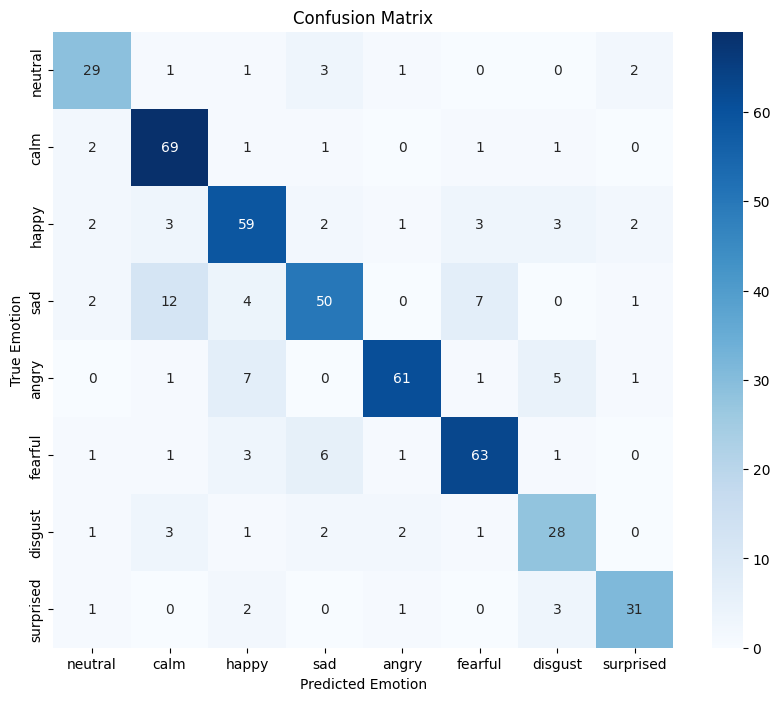

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

int_to_emotion = {
    0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad',
    4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'
}
emotion_names = [int_to_emotion[i] for i in range(len(int_to_emotion))]

# y_true and y_pred must be arrays of integer class indices (not one-hot)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_names,
            yticklabels=emotion_names)
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()


In [23]:
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred, int_to_emotion):
    emotion_names = [int_to_emotion[i] for i in range(len(int_to_emotion))]
    report = classification_report(y_true, y_pred, target_names=emotion_names)
    print(report)

print_classification_report(y_true, y_pred, int_to_emotion)



            precision    recall  f1-score   support

    neutral      0.76      0.78      0.77        37
       calm      0.77      0.92      0.84        75
      happy      0.76      0.79      0.77        75
        sad      0.78      0.66      0.71        76
      angry      0.91      0.80      0.85        76
    fearful      0.83      0.83      0.83        76
    disgust      0.68      0.74      0.71        38
  surprised      0.84      0.82      0.83        38

   accuracy                          0.80       491
  macro avg      0.80      0.80      0.80       491
weighted avg      0.80      0.80      0.80       491


In [ ]:
# import os
# import numpy as np
# import librosa
# import soundfile as sf
# import streamlit as st
# import numpy as np
# import librosa
# import joblib
# from keras.models import load_model
# import torchaudio
# import torch
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# import pandas as pd

# # from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# int_to_emotion = {
#     0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad',
#     4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'
# }


# # --- Load models and preprocessors ---
# model_female = load_model(r"female_models\female_model.keras")
# model_male = load_model("male_models\\male_model.keras")
# scaler_female = joblib.load("female_models\\female_scaler.pkl")
# scaler_male = joblib.load("male_models\\male_scaler.pkl")


# from voice_gender_classifier.model import ECAPA_gender

# gender_model = ECAPA_gender.from_pretrained("JaesungHuh/voice-gender-classifier")
# gender_model.eval()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# gender_model.to(device)

# def predict_gender(file):
#     with torch.no_grad():
#         return gender_model.predict(file, device=device)



# # --- Your Feature Extraction Function ---
# def extract_features(audio, sr, n_mfcc=40, n_chroma=12, n_bands=6):
#     stft = np.abs(librosa.stft(audio))
#     mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
#     mfccs_processed = np.vstack([np.mean(mfccs, axis=1), np.std(mfccs, axis=1), np.median(mfccs, axis=1)])
#     chroma = librosa.feature.chroma_stft(S=stft, sr=sr, n_chroma=n_chroma)
#     chroma_processed = np.vstack([np.mean(chroma, axis=1), np.std(chroma, axis=1)])
#     contrast = librosa.feature.spectral_contrast(S=stft, sr=sr, n_bands=n_bands)
#     contrast_processed = np.vstack([np.mean(contrast, axis=1), np.std(contrast, axis=1)])
#     tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)
#     tonnetz_processed = np.vstack([np.mean(tonnetz, axis=1), np.std(tonnetz, axis=1)])
#     centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
#     bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
#     rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
#     flatness = librosa.feature.spectral_flatness(y=audio)
#     spectral_features = np.array([np.mean(centroid), np.std(centroid), np.mean(bandwidth), np.std(bandwidth),
#                                   np.mean(rolloff), np.std(rolloff), np.mean(flatness), np.std(flatness)])
#     zero_crossing = librosa.feature.zero_crossing_rate(audio)
#     rms = librosa.feature.rms(y=audio)
#     temporal_features = np.array([np.mean(zero_crossing), np.std(zero_crossing), np.mean(rms), np.std(rms)])
#     mel = librosa.feature.melspectrogram(y=audio, sr=sr)
#     mel_processed = np.array([np.mean(mel), np.std(mel), np.median(mel), np.max(mel)])
#     return np.hstack([mfccs_processed.flatten(), chroma_processed.flatten(), contrast_processed.flatten(),
#                       tonnetz_processed.flatten(), spectral_features, temporal_features, mel_processed])



# # --- Streamlit UI ---
# st.title("🎙️ Emotion Detection App")
# st.markdown("Upload a `.wav` file. The system will detect gender and predict the emotion.")

# uploaded_file = st.file_uploader("Upload your voice (.wav)", type=["wav"])

# if uploaded_file is not None:
#     st.audio(uploaded_file, format='audio/wav')
    
#     # Save to temp file for both torchaudio and librosa use
#     temp_path = "temp_audio.wav"
#     with open(temp_path, "wb") as f:
#         f.write(uploaded_file.read())
    
#     # Gender prediction
#     gender = predict_gender(temp_path)
#     st.write(f"**Predicted Gender:** `{gender}`")
    
#     # Feature extraction
    
    
#     # Choose model
#     if gender == 'female':
#         audio, sr = librosa.load(temp_path, sr=16000)
#         features = extract_features(audio, sr)
#         features_scaled = scaler_female.transform([features])
#         features_input = features_scaled.reshape((1, features_scaled.shape[1], 1))  # CNN shape
#         probs = model_female.predict(features_input)[0]
#         predicted_class = int_to_emotion[np.argmax(probs)]
#     else:
#         audio, sr = librosa.load(temp_path, sr=16000)
#         features = extract_features(audio, sr)
#         features_scaled = scaler_male.transform([features])
#         features_input = features_scaled.reshape((1, features_scaled.shape[1], 1))  # CNN shape
#         probs = model_male.predict(features_input)[0]
#         predicted_class = int_to_emotion[np.argmax(probs)]
#     # predicted_class = label_encoder.inverse_transform([np.argmax(probs)])[0]
    
#     st.success(f"**Predicted Emotion:** `{predicted_class}`")
#     st.bar_chart(probs)

#     # Cleanup
#     os.remove(temp_path)
